In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [4]:
import yfinance as yf

df = yf.download("TATAMOTORS.NS", period="8y", interval="1d")
csv_path = "/content/drive/MyDrive/Colab_Stock/TATA_8y(17-25).csv"
df.to_csv(csv_path)
df

/tmp/ipython-input-4-4040462576.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("TATAMOTORS.NS", period="8y", interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS
Date,,,,,
2017-07-03,423.948639,428.333477,420.007222,425.180332,6230025
2017-07-04,420.647705,430.008570,419.760892,427.840809,5020683
2017-07-05,425.426697,427.594488,421.140400,422.618431,5050749
2017-07-06,430.698364,432.373449,427.446677,429.023250,4038188
2017-07-07,430.451996,434.984631,425.919360,428.087152,5311730
...,...,...,...,...,...
2025-06-27,686.900024,691.450012,683.000000,685.000000,7198028
2025-06-30,688.000000,691.900024,685.000000,688.900024,6960104


In [5]:
df_clean = df[['Open', 'High', 'Close']]
# Date already comes in datetime format and as index
df_clean

#print(df_clean.index)

#df_clean.loc["2020-03-23"] # to get a particular date's data

Price,Open,High,Close
Ticker,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS
Date,,,
2017-07-03,425.180332,428.333477,423.948639
2017-07-04,427.840809,430.008570,420.647705
2017-07-05,422.618431,427.594488,425.426697
2017-07-06,429.023250,432.373449,430.698364
2017-07-07,428.087152,434.984631,430.451996
...,...,...,...
2025-06-27,685.000000,691.450012,686.900024
2025-06-30,688.900024,691.900024,688.000000


In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

def plot_graph(df_clean):

    # Closing prices for 8 years
    plt.figure(figsize=(12,5))
    plt.plot(df_clean.index, df_clean['Close'], color='blue')
    plt.title("Stock Prices of Last 8 Years")
    plt.xlabel("Date")
    plt.ylabel("Closing Prices")
    plt.show()

    print("\n")

    # Trend, Seasonality, Residual Plot
    close_series = df_clean["Close"].dropna()
    decomposition = seasonal_decompose(close_series, model='multiplicative', period=252)

    plt.figure(figsize=(12,8))

    plt.subplot(3, 1, 1)
    plt.plot(decomposition.trend, color='black')
    plt.title("Trend")

    print("\n\n")

    plt.subplot(3, 1, 2)
    plt.plot(decomposition.seasonal, color='orange')
    plt.title("Seasonality")

    print("\n\n")

    plt.subplot(3, 1, 3)
    plt.plot(decomposition.resid, color='red')
    plt.title("Residual (Noise)")
    plt.show()

    print("\n\n")
    # PACF Plot
    plt.figure(figsize=(12, 5))
    plot_pacf(close_series, lags=30, method='ywm')
    plt.title("Partial Autocorrelation Function (PACF)")
    plt.show()

    print("\n\n\n")

    # 30-day moving average
    df_clean['MA_30'] = df_clean['Close'].rolling(window=30).mean()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(df_clean['Close'], label='Close Price', linewidth=1.5)
    plt.plot(df_clean['MA_30'], label='30-Day Moving Average', color='orange', linewidth=2)
    plt.title('Close Price vs 30-Day Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


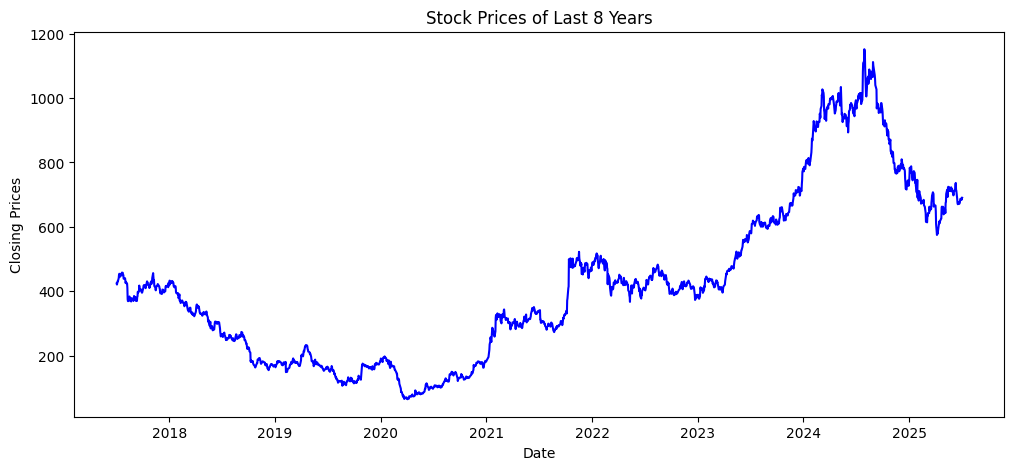

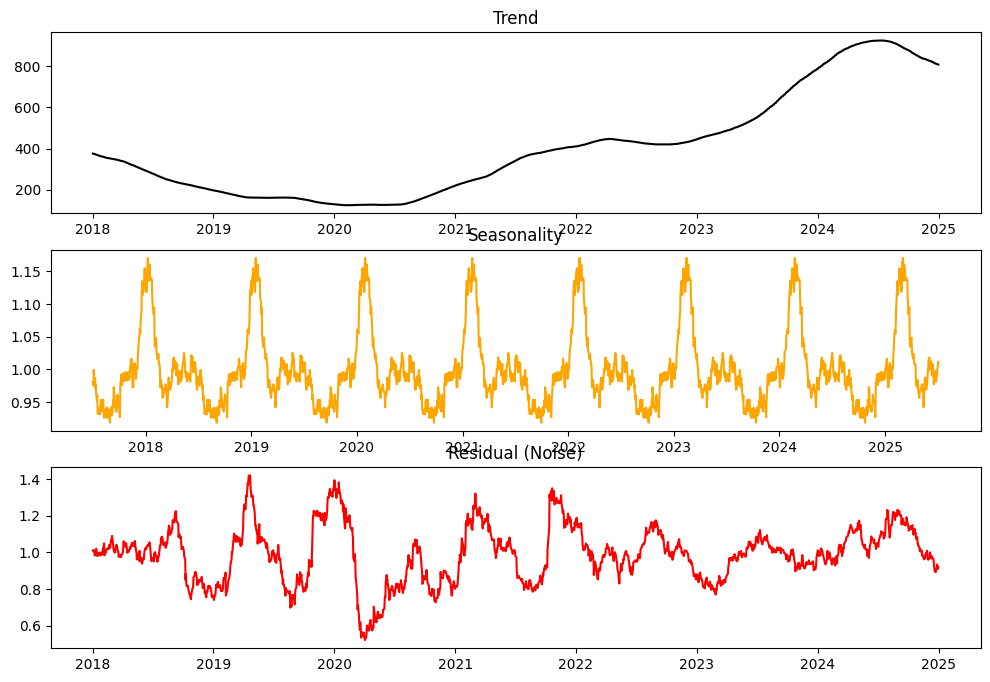

<Figure size 1200x500 with 0 Axes>

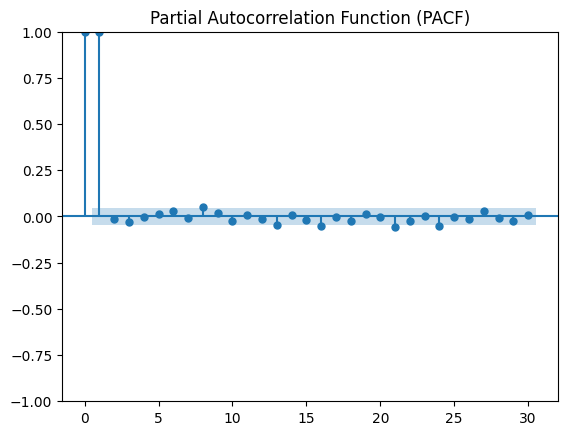

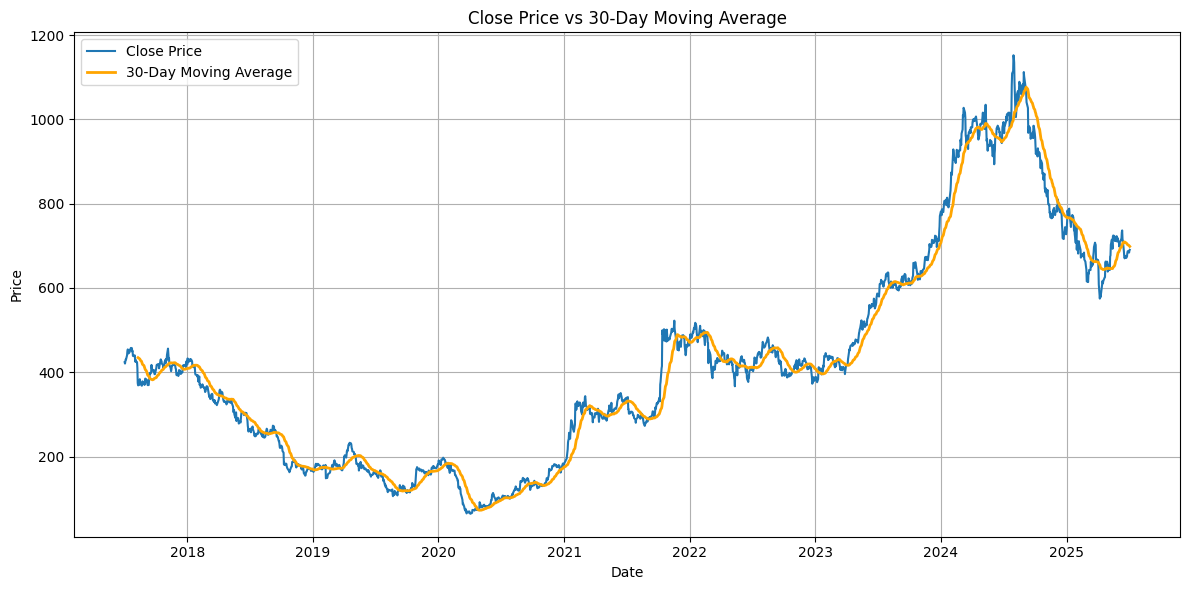

In [10]:
plot_graph(df_clean)

In [13]:
# training data, validation data and test data

# We will try to change the ratios if accuaracy not satisfactory for model training.
import pandas as pd
import numpy as np

def split_df_clean(df_clean, train_ratio=0.875, val_ratio=0.0625):

    df_clean = df_clean[['Open', 'High', 'Close']].dropna().copy()

    total_len = len(df_clean)
    train_end = int(total_len * train_ratio)
    val_end = train_end + int(total_len * val_ratio)

    df_train = df_clean.iloc[:train_end]
    df_val   = df_clean.iloc[train_end:val_end]
    df_test  = df_clean.iloc[val_end:]

    return df_train, df_val, df_test

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess_stock_data_lstm(df_split, lags=30, scaler=None, is_train=True):
    df_split = df_split[['Open', 'High', 'Close']].dropna().copy()

    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df_split)
    else:
        scaled_values = scaler.transform(df_split)

    df_scaled = pd.DataFrame(scaled_values, columns=['Open', 'High', 'Close'], index=df_split.index)

    X, y = [], []
    for i in range(lags, len(df_scaled)):
        X.append(df_scaled.iloc[i-lags:i].values)
        y.append(df_scaled.iloc[i]['Close'])

    return np.array(X), np.array(y), scaler

In [16]:
df_train, df_val, df_test = split_df_clean(df_clean)

X_train, y_train, tata_scaler = preprocess_stock_data_lstm(df_train, lags=30, scaler=None, is_train=True)
X_val, y_val, _          = preprocess_stock_data_lstm(df_val,   lags=30, scaler=tata_scaler, is_train=False)
X_test, y_test, _        = preprocess_stock_data_lstm(df_test,  lags=30, scaler=tata_scaler, is_train=False)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (1700, 30, 3) (1700,)
Val  : (93, 30, 3) (93,)
Test : (95, 30, 3) (95,)


In [17]:
# Model making (LSTM)

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop


!pip install -U keras-tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.0 MB/s eta 0:00:00


In [50]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

!pip install -U keras-tuner
import keras_tuner as kt

def build_model(hp):

    model = Sequential()

    num_layers = hp.Int('num_layers', min_value=1, max_value=8)  # ✅ Called only once

    for i in range(num_layers):
        units = hp.Int(f'units_{i}', min_value=8, max_value=512, step=8)
        activation = hp.Choice(f'activation_{i}', values=['relu', 'tanh'])
        dropout_rate = hp.Choice(f'dropout_{i}', values=[0.1, 0.2, 0.3, 0.4, 0.5])

        return_seq = True if i < num_layers - 1 else False

        if i == 0:
            model.add(LSTM(units, activation=activation, return_sequences=return_seq,
                           input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            model.add(LSTM(units, activation=activation, return_sequences=return_seq))

        model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    optimizer = hp.Choice("optimizer_", values=['rmsprop', 'adam'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# -------------------------------------------------------------------------------------------

tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=8)

tuner.search(X_train, y_train, epochs=12, validation_data=(X_val, y_val))

model = tuner.get_best_models(num_models=1)[0]

model.summary()

history = model.fit(X_train, y_train, batch_size=32, epochs=70, initial_epoch=12, validation_data=(X_val, y_val))


Trial 8 Complete [00h 00m 13s]
val_loss: 0.0004840905894525349

Best val_loss So Far: 0.0004840905894525349
Total elapsed time: 00h 37m 53s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 152)            │        94,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 152)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,001 (371.10 KB)

 Trainable params: 95,001 (371.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 13/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 7.6120e-04 - mae: 0.0195 - val_loss: 0.0014 - val_mae: 0.0312
Epoch 14/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.0563e-04 - mae: 0.0168 - val_loss: 0.0013 - val_mae: 0.0304
Epoch 15/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.4430e-04 - mae: 0.0175 - val_loss: 6.5361e-04 - val_mae: 0.0205
Epoch 16/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.2952e-04 - mae: 0.0180 - val_loss: 0.0013 - val_mae: 0.0301
Epoch 17/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.7588e-04 - mae: 0.0174 - val_loss: 4.4765e-04 - val_mae: 0.0163
Epoch 18/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2709e-04 - mae: 0.0160 - val_loss: 4.0039e-04 - val_mae: 0.0157
Epoch 19/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.1706e-04 - mae: 0.0172 - val_loss: 8.1771e-04 - val_mae: 0.0234
Epoch 20/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.0972e-04 - mae: 0.0200 - val_loss: 4.5899e-04 - val_mae: 0.0163
Epoch 21/7

In [51]:
y_test = y_test.reshape(-1)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (1700, 30, 3) (1700,)
Val  : (93, 30, 3) (93,)
Test : (95, 30, 3) (95,)


In [52]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 3.4617e-04 - mae: 0.0146
Test Loss: 0.0003367916215211153, Test MAE: 0.014406678266823292


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


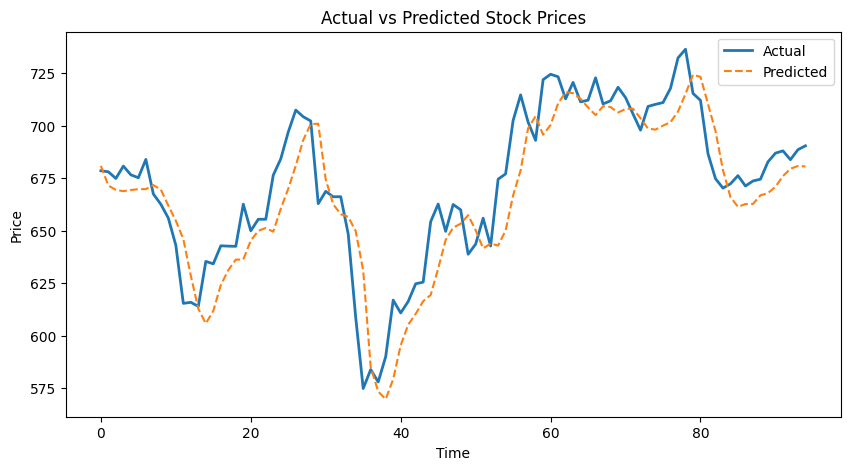

In [53]:
#plot actual vs predicted

y_pred = model.predict(X_test)

# Create dummy arrays for 'Open' and 'High' with the same shape as y_pred/y_test
dummy_open = np.zeros_like(y_pred)
dummy_high = np.zeros_like(y_pred)

# Combine predicted/actual 'Close' with dummy 'Open' and 'High'
y_pred_combined = np.hstack((dummy_open, dummy_high, y_pred))
y_test_combined = np.hstack((dummy_open, dummy_high, y_test.reshape(-1, 1)))

# Inverse transform the combined arrays
y_pred_inv = tata_scaler.inverse_transform(y_pred_combined)[:, 2] # Extract the inverse transformed 'Close'
y_test_inv = tata_scaler.inverse_transform(y_test_combined)[:, 2] # Extract the inverse transformed 'Close'

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual', linewidth=2)
plt.plot(y_pred_inv, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [54]:
model.save('/content/drive/MyDrive/Colab_Stock/TATA_model.keras')

In [55]:
import joblib
joblib.dump(tata_scaler, "/content/drive/MyDrive/Colab_Stock/tata_scaler.save")

['/content/drive/MyDrive/Colab_Stock/tata_scaler.save']

In [56]:
import json

metrics = {
    "val_loss": float(history.history['val_loss'][-1]),
    "val_mae": float(history.history['val_mae'][-1]),
    "train_loss": float(history.history['loss'][-1]),
    "train_mae": float(history.history['mae'][-1]),
    "epochs": len(history.history['loss']),
    "model_name": "TATA_model.keras"
}

with open('/content/drive/MyDrive/Colab_Stock/tata_model_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)
